In [159]:
# %pip install torch torch_geometric pytorch_lightning wandb scikit-learn matplotlib

In [160]:
import torch
from torch_geometric.data import Data
import pandas as pd
import wandb
from sklearn.preprocessing import MultiLabelBinarizer
import ast
import numpy as np

pd.set_option('display.max_columns', None)

# Load the data

In [161]:
df = pd.read_csv('../get_lineup_target_score/nba_with_lineup_score.csv')
pre_df = pd.read_csv('../pre_season/pre_lineup_vs_lineup.csv')
pre_player_stats_df = pd.read_csv('../../data/player_stats_2023-24.csv')

In [162]:
pre_df.fillna(0, inplace=True)

In [163]:
df.dropna(subset=['net_score'], inplace=True)
df = df[~df['net_score'].isin([np.inf, -np.inf])]

In [164]:
df.size

91200

In [165]:
all_lineups = pd.concat([df['home_lineup'], df['away_lineup']]).unique()
pre_df_lineups = pd.concat([pre_df['home_lineup'], pre_df['away_lineup']]).unique()
filtered_lineups = [lineup for lineup in all_lineups if lineup in pre_df_lineups]
all_lineups = np.array(filtered_lineups)

In [166]:
all_lineups.size

968

In [167]:
df = df[df['home_lineup'].isin(all_lineups) & df['away_lineup'].isin(all_lineups)]
pre_df = pre_df[pre_df['home_lineup'].isin(all_lineups) & pre_df['away_lineup'].isin(all_lineups)]

In [168]:
lineups_df = pd.DataFrame(all_lineups, columns=['lineup'])
lineups_df["3pt_made"] = 0
lineups_df["points"] = 0
lineups_df["assists"] = 0
lineups_df["def_rebounds"] = 0
lineups_df["off_rebounds"] = 0
lineups_df["fouls"] = 0
lineups_df["2pt_made"] = 0
lineups_df["turnovers"] = 0
lineups_df["ft_made"] = 0
lineups_df["steals"] = 0
lineups_df["blocks"] = 0

In [169]:
cols = ['3pt_made', 'points', 'assists', 'def_rebounds', 'off_rebounds', 'fouls', '2pt_made', 'turnovers', 'ft_made', 'steals', 'blocks']
for index, row in pre_df.iterrows():
    home_lineup = row['home_lineup']
    away_lineup = row['away_lineup']
    
    for col in cols:
        home_col = 'home_' + col
        away_col = 'away_' + col
        if home_col in row and away_col in row:
            lineups_df.loc[lineups_df['lineup'] == home_lineup, col] += row[home_col]
            lineups_df.loc[lineups_df['lineup'] == away_lineup, col] += row[away_col]
        else:
            print(f'Column {home_col} or {away_col} not found in row')

In [170]:
pre_player_stats_df

,PLAYER_ID,PLAYER_NAME,TEAM_ID,GP,MIN,PTS,AST,REB,STL,BLK,TOV
0,1630639,A.J. Lawson,1610612742,4,38.000000,18,1,12,3,1,1
1,1631260,AJ Green,1610612749,3,36.833333,25,3,6,2,0,2
2,1631100,AJ Griffin,1610612737,5,100.783333,39,5,10,6,0,4
3,203932,Aaron Gordon,1610612743,4,82.600000,32,9,18,1,3,6
4,1628988,Aaron Holiday,1610612745,5,74.611667,17,14,15,2,1,5
...,...,...,...,...,...,...,...,...,...,...,...
565,1630285,Zavier Simpson,1610612763,2,27.483333,6,7,5,0,0,2
566,1630192,Zeke Nnaji,1610612743,5,95.360000,46,8,24,4,6,3
567,1629015,Zhaire Smith,1610612739,3,20.083333,2,2,5,3,0,0
568,1630533,Ziaire Williams,1610612763,5,102.950000,62,8,18,4,3,6


In [171]:

# Parse the lineup strings into tuples
lineups_df['lineup_tuple'] = lineups_df['lineup'].apply(lambda x: ast.literal_eval(x))

# Create a dictionary mapping player names to their stats
player_stats_dict = pre_player_stats_df.set_index('PLAYER_NAME').to_dict('index')

# Initialize columns for aggregated stats
stat_columns = ['PTS', 'AST', 'REB', 'STL', 'BLK', 'TOV']
for col in stat_columns:
    lineups_df[col] = 0

num_lineups_to_not_aggregate = 0

# Aggregate stats for each lineup
for index, row in lineups_df.iterrows():
    lineup = row['lineup_tuple']
    for player in lineup:
        if player in player_stats_dict:
            player_stats = player_stats_dict[player]
            for col in stat_columns:
                lineups_df.at[index, col] += player_stats.get(col, 0)
        else:
            # Delete the lineup if any player is not found in player stats
            lineups_df.drop(index=index, inplace=True)
            num_lineups_to_not_aggregate += 1
            break
lineups_df.reset_index(drop=True, inplace=True)

# Normalize the specified columns
for col in stat_columns:
    max_value = lineups_df[col].max()
    if max_value > 0:  # Avoid division by zero
        lineups_df[col] = lineups_df[col] / max_value

In [172]:
def create_lineup_graph(df, pre_df):
    all_lineups = pd.concat([df['home_lineup'], df['away_lineup']]).unique()
    pre_df_lineups = pd.concat([pre_df['home_lineup'], pre_df['away_lineup']]).unique()
    filtered_lineups = [lineup for lineup in all_lineups if lineup in pre_df_lineups]
    all_lineups = np.array(filtered_lineups)

    df = df[df['home_lineup'].isin(all_lineups) & df['away_lineup'].isin(all_lineups)]
    pre_df = pre_df[pre_df['home_lineup'].isin(all_lineups) & pre_df['away_lineup'].isin(all_lineups)]

    lineups_df = pd.DataFrame(all_lineups, columns=['lineup'])
    lineups_df["3pt_made"] = 0
    lineups_df["points"] = 0
    lineups_df["assists"] = 0
    lineups_df["def_rebounds"] = 0
    lineups_df["off_rebounds"] = 0
    lineups_df["fouls"] = 0
    lineups_df["2pt_made"] = 0
    lineups_df["turnovers"] = 0
    lineups_df["ft_made"] = 0
    lineups_df["steals"] = 0
    lineups_df["blocks"] = 0

    cols = ['3pt_made', 'points', 'assists', 'def_rebounds', 'off_rebounds', 'fouls', '2pt_made', 'turnovers', 'ft_made', 'steals', 'blocks']
    for index, row in pre_df.iterrows():
        home_lineup = row['home_lineup']
        away_lineup = row['away_lineup']
        
        for col in cols:
            home_col = 'home_' + col
            away_col = 'away_' + col
            if home_col in row and away_col in row:
                lineups_df.loc[lineups_df['lineup'] == home_lineup, col] += row[home_col]
                lineups_df.loc[lineups_df['lineup'] == away_lineup, col] += row[away_col]
            else:
                print(f'Column {home_col} or {away_col} not found in row')
    
    # Create unique lineup nodes
    lineup2idx = {lineup: idx for idx, lineup in enumerate(lineups_df['lineup'])}
    
    # Create node features based on lineups_df
    x = torch.tensor(lineups_df.iloc[:, 1:].values, dtype=torch.float)
    
    # Create directed edges with score-based direction
    edge_index = []
    edge_attr = []
    
    for _, row in df.iterrows():
        home = row['home_lineup']
        away = row['away_lineup']
        home_idx = lineup2idx[home]
        away_idx = lineup2idx[away]
        
        # Determine edge direction based on normalized scores
        if row['normalized_home_score'] > row['normalized_away_score']:
            src, dst = home_idx, away_idx
        else:
            src, dst = away_idx, home_idx
            
        edge_index.append([src, dst])
        edge_attr.append(abs(row['net_score']))
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).unsqueeze(1)
    
    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        num_nodes=len(lineups_df))

In [173]:
data = create_lineup_graph(df, pre_df)

In [174]:
data

Data(x=[678, 11], edge_index=[2, 781], edge_attr=[781, 1], num_nodes=678)

# GNN Model

In [175]:
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GINEConv
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import Accuracy, AUROC

In [176]:
class GNNModel(nn.Module):
    def __init__(self, input_dim, num_layers, hidden_dim, dropout_rate):
        super().__init__()
        self.convs = nn.ModuleList()
        self.dropout_rate = dropout_rate
        for _ in range(num_layers):
            conv = GINEConv(
                nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, hidden_dim),
                ),
                train_eps=True,
                edge_dim=1,
            )
            self.convs.append(conv)
            input_dim = hidden_dim
    
    def forward(self, x, edge_index, edge_attr):
        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout_rate, training=self.training)
        return x

# Link Prediction Decoder with Edge Attributes
class LinkPredictor(nn.Module):
    def __init__(self, num_layers, hidden_dim):
        super().__init__()
        mlp_layers = []
        current_dim = 2 * hidden_dim
        for _ in range(num_layers):
            mlp_layers.append(nn.Linear(current_dim, hidden_dim))
            mlp_layers.append(nn.ReLU())
            current_dim = hidden_dim
        mlp_layers.append(nn.Linear(hidden_dim, 1))
        mlp_layers.append(nn.Sigmoid())
        self.mlp = nn.Sequential(*mlp_layers)
    
    def forward(self, u_emb, v_emb):
        concatenated = torch.cat([u_emb, v_emb], dim=1)
        return self.mlp(concatenated).squeeze()

# Lightning Module for Training
class LitGNN(pl.LightningModule):
    def __init__(self,
                input_dim,
                # Conv layer parameters
                conv_layers=2,
                conv_hidden_dim=64,
                # Link prediction parameters
                link_predictor_layers=1,
                link_hidden_dim=64,
                # Training parameters
                learning_rate=0.001,
                weight_decay=0.0001,
                dropout_rate=0.5):
        super().__init__()
        self.save_hyperparameters()
        self.gnn = GNNModel(input_dim, conv_layers, conv_hidden_dim, dropout_rate)
        self.link_predictor = LinkPredictor(link_predictor_layers, link_hidden_dim)
        self.loss_fn = nn.BCELoss()

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        # Initialize metrics
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')
        self.train_auroc = AUROC(task='binary')
        self.val_auroc = AUROC(task='binary')
        self.test_auroc = AUROC(task='binary')
    
    def forward(self, x, edge_index, edge_attr):
        return self.gnn(x, edge_index, edge_attr)
    
    def training_step(self, batch, batch_idx):
        x, edge_index, edge_attr = batch.x, batch.edge_index, batch.edge_attr
        edge_label_index, edge_label = batch.edge_label_index, batch.edge_label

        node_emb = self.gnn(x, edge_index, edge_attr)
        u_emb = node_emb[edge_label_index[0]]
        v_emb = node_emb[edge_label_index[1]]
        preds = self.link_predictor(u_emb, v_emb)

        loss = self.loss_fn(preds, edge_label.float())
        self.log('train_loss', loss, prog_bar=True)
        # print(f"Train Loss: {loss:.4f}")

        # Calculate accuracy
        preds_binary = (preds > 0.5).int()
        acc = self.train_acc(preds_binary, edge_label.int())
        self.log('train_acc', acc, prog_bar=True)
        # print(f"Train Accuracy: {acc:.4f}")

        # Calculate AUC-ROC
        if len(torch.unique(edge_label)) > 1:
            auc = self.train_auroc(preds, edge_label.int())
            self.log('train_auc', auc, prog_bar=True)
            # print(f"Train AUC: {auc:.4f}")

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, edge_index, edge_attr = batch.x, batch.edge_index, batch.edge_attr
        edge_label_index, edge_label = batch.edge_label_index, batch.edge_label

        node_emb = self.gnn(x, edge_index, edge_attr)
        u_emb = node_emb[edge_label_index[0]]
        v_emb = node_emb[edge_label_index[1]]
        preds = self.link_predictor(u_emb, v_emb)

        loss = self.loss_fn(preds, edge_label.float())
        self.log('val_loss', loss, prog_bar=True)

        # Calculate accuracy
        preds_binary = (preds > 0.5).int()
        acc = self.val_acc(preds_binary, edge_label.int())
        self.log('val_acc', acc, prog_bar=True)

        # Calculate AUC-ROC
        if len(torch.unique(edge_label)) > 1:  # Ensure both classes are present
            auc = self.val_auroc(preds, edge_label.int())
            self.log('val_auc', auc, prog_bar=True)

        return loss
    
    def test_step(self, batch, batch_idx):
        x, edge_index, edge_attr = batch.x, batch.edge_index, batch.edge_attr
        edge_label_index, edge_label = batch.edge_label_index, batch.edge_label

        node_emb = self.gnn(x, edge_index, edge_attr)
        u_emb = node_emb[edge_label_index[0]]
        v_emb = node_emb[edge_label_index[1]]
        preds = self.link_predictor(u_emb, v_emb)

        loss = self.loss_fn(preds, edge_label.float())
        self.log('test_loss', loss, prog_bar=True)

        # Calculate accuracy
        preds_binary = (preds > 0.5).int()
        acc = self.test_acc(preds_binary, edge_label.int())
        self.log('test_acc', acc, prog_bar=True)

        # Calculate AUC-ROC
        if len(torch.unique(edge_label)) > 1:
            auc = self.test_auroc(preds, edge_label.int())
            self.log('test_auc', auc, prog_bar=True)

        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay,
        )

In [177]:
# Function to add reversed edges as negatives to a Data object
def add_reversed_negatives(data):
    if data.edge_index.size(1) == 0:
        return data  # Skip if no edges
    original_edges = data.edge_index
    reversed_edges = torch.flip(original_edges, dims=[0])
    
    # Combine original and reversed edges
    edge_label_index = torch.cat([original_edges, reversed_edges], dim=1)
    edge_label = torch.cat([
        torch.ones(original_edges.size(1)),
        torch.zeros(reversed_edges.size(1))
    ])
    
    # Use original edge_attr for both directions
    edge_label_attr = torch.cat([data.edge_attr, data.edge_attr], dim=0)
    
    # Shuffle the combined data
    perm = torch.randperm(edge_label_index.size(1))
    edge_label_index = edge_label_index[:, perm]
    edge_label_attr = edge_label_attr[perm]
    edge_label = edge_label[perm]
    
    data.edge_label_index = edge_label_index
    data.edge_label_attr = edge_label_attr
    data.edge_label = edge_label
    return data

In [178]:
batch_size = 1
train_data, val_data, test_data = RandomLinkSplit(num_val=0.1, num_test=0.1)(data)
train_data = add_reversed_negatives(train_data)
val_data = add_reversed_negatives(val_data)
test_data = add_reversed_negatives(test_data)
train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
val_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)
test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

In [183]:
model = LitGNN(input_dim=data.x.shape[1])

trainer = pl.Trainer(
    max_epochs=500,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min'),
        pl.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min')
    ],
)

trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | gnn            | GNNModel       | 13.4 K | train
1 | link_predictor | LinkPredictor  | 8.3 K  | train
2 | loss_fn        | BCELoss        | 0      | train
3 | train_acc      | BinaryAccuracy | 0      | train
4 | val_acc        | BinaryAccuracy | 0      | train
5 | test_acc       | BinaryAccuracy | 0      | train
6 | train_auroc    | BinaryAUROC    | 0      | train
7 | val_auroc      | BinaryAUROC    | 0      | train
8 | test_auroc     | BinaryAUROC    | 0      | train
----------------------------------------------------------
21.7 K    Trainable params
0         Non-trainable params
21.7 K    Total params
0.087     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 16.53it/s, v_num=75, train_loss=0.703, train_acc=0.523, train_auc=0.516, val_loss=0.685, val_acc=0.682, val_auc=0.728]

Metric val_loss improved. New best score: 0.685


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 20.41it/s, v_num=75, train_loss=0.700, train_acc=0.582, train_auc=0.591, val_loss=0.681, val_acc=0.715, val_auc=0.750]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.681


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 21.43it/s, v_num=75, train_loss=0.686, train_acc=0.609, train_auc=0.629, val_loss=0.678, val_acc=0.735, val_auc=0.761]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.678


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s, v_num=75, train_loss=0.692, train_acc=0.664, train_auc=0.690, val_loss=0.676, val_acc=0.738, val_auc=0.763]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.676


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 21.28it/s, v_num=75, train_loss=0.685, train_acc=0.675, train_auc=0.705, val_loss=0.675, val_acc=0.741, val_auc=0.762]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.675


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 22.69it/s, v_num=75, train_loss=0.669, train_acc=0.718, train_auc=0.732, val_loss=0.675, val_acc=0.746, val_auc=0.761]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.675


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 23.81it/s, v_num=75, train_loss=0.686, train_acc=0.702, train_auc=0.706, val_loss=0.673, val_acc=0.744, val_auc=0.761]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.673


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 24.49it/s, v_num=75, train_loss=0.677, train_acc=0.726, train_auc=0.731, val_loss=0.671, val_acc=0.742, val_auc=0.762]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.671


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s, v_num=75, train_loss=0.689, train_acc=0.721, train_auc=0.733, val_loss=0.669, val_acc=0.739, val_auc=0.763]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.669


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s, v_num=75, train_loss=0.669, train_acc=0.735, train_auc=0.751, val_loss=0.667, val_acc=0.733, val_auc=0.762]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.667


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s, v_num=75, train_loss=0.724, train_acc=0.731, train_auc=0.740, val_loss=0.665, val_acc=0.739, val_auc=0.763]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.665


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s, v_num=75, train_loss=0.677, train_acc=0.727, train_auc=0.741, val_loss=0.663, val_acc=0.737, val_auc=0.766]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.663


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 21.28it/s, v_num=75, train_loss=0.659, train_acc=0.732, train_auc=0.748, val_loss=0.660, val_acc=0.730, val_auc=0.768]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.660


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s, v_num=75, train_loss=0.656, train_acc=0.734, train_auc=0.753, val_loss=0.657, val_acc=0.730, val_auc=0.769]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.657


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 20.13it/s, v_num=75, train_loss=0.656, train_acc=0.727, train_auc=0.749, val_loss=0.652, val_acc=0.730, val_auc=0.771]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.652


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 20.85it/s, v_num=75, train_loss=0.659, train_acc=0.730, train_auc=0.754, val_loss=0.648, val_acc=0.737, val_auc=0.774]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.648


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s, v_num=75, train_loss=0.660, train_acc=0.734, train_auc=0.748, val_loss=0.644, val_acc=0.733, val_auc=0.775]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.644


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 23.94it/s, v_num=75, train_loss=0.661, train_acc=0.740, train_auc=0.763, val_loss=0.640, val_acc=0.732, val_auc=0.776]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.640


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 23.81it/s, v_num=75, train_loss=0.640, train_acc=0.730, train_auc=0.765, val_loss=0.636, val_acc=0.730, val_auc=0.777]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.636


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s, v_num=75, train_loss=0.643, train_acc=0.730, train_auc=0.755, val_loss=0.631, val_acc=0.730, val_auc=0.777]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.631


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s, v_num=75, train_loss=0.637, train_acc=0.726, train_auc=0.762, val_loss=0.627, val_acc=0.732, val_auc=0.778]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.627


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s, v_num=75, train_loss=0.651, train_acc=0.706, train_auc=0.744, val_loss=0.622, val_acc=0.729, val_auc=0.778]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.622


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s, v_num=75, train_loss=0.629, train_acc=0.724, train_auc=0.762, val_loss=0.617, val_acc=0.726, val_auc=0.776]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.617


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s, v_num=75, train_loss=0.625, train_acc=0.734, train_auc=0.775, val_loss=0.612, val_acc=0.726, val_auc=0.776]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.612


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s, v_num=75, train_loss=0.623, train_acc=0.742, train_auc=0.775, val_loss=0.606, val_acc=0.725, val_auc=0.775]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.606


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s, v_num=75, train_loss=0.636, train_acc=0.722, train_auc=0.755, val_loss=0.600, val_acc=0.726, val_auc=0.776]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.600


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s, v_num=75, train_loss=0.622, train_acc=0.722, train_auc=0.758, val_loss=0.594, val_acc=0.722, val_auc=0.779]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.594


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s, v_num=75, train_loss=0.605, train_acc=0.738, train_auc=0.777, val_loss=0.588, val_acc=0.722, val_auc=0.782]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.588


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s, v_num=75, train_loss=0.625, train_acc=0.734, train_auc=0.771, val_loss=0.583, val_acc=0.723, val_auc=0.786]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.583


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s, v_num=75, train_loss=0.602, train_acc=0.726, train_auc=0.773, val_loss=0.578, val_acc=0.724, val_auc=0.789]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.578


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s, v_num=75, train_loss=0.587, train_acc=0.730, train_auc=0.787, val_loss=0.574, val_acc=0.724, val_auc=0.790]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.574


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s, v_num=75, train_loss=0.596, train_acc=0.750, train_auc=0.786, val_loss=0.570, val_acc=0.722, val_auc=0.793]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.570


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s, v_num=75, train_loss=0.585, train_acc=0.722, train_auc=0.785, val_loss=0.567, val_acc=0.718, val_auc=0.795]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.567


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s, v_num=75, train_loss=0.580, train_acc=0.726, train_auc=0.776, val_loss=0.564, val_acc=0.722, val_auc=0.798]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.564


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s, v_num=75, train_loss=0.579, train_acc=0.733, train_auc=0.778, val_loss=0.562, val_acc=0.725, val_auc=0.800]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.562


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  6.83it/s, v_num=75, train_loss=0.588, train_acc=0.715, train_auc=0.783, val_loss=0.560, val_acc=0.722, val_auc=0.800]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.560


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 15.00it/s, v_num=75, train_loss=0.572, train_acc=0.724, train_auc=0.792, val_loss=0.558, val_acc=0.724, val_auc=0.800]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.558


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s, v_num=75, train_loss=0.594, train_acc=0.702, train_auc=0.770, val_loss=0.557, val_acc=0.728, val_auc=0.801]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.557


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 14.48it/s, v_num=75, train_loss=0.567, train_acc=0.719, train_auc=0.793, val_loss=0.556, val_acc=0.729, val_auc=0.798]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.556


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 14.98it/s, v_num=75, train_loss=0.576, train_acc=0.715, train_auc=0.781, val_loss=0.554, val_acc=0.727, val_auc=0.800]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.554


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s, v_num=75, train_loss=0.573, train_acc=0.722, train_auc=0.778, val_loss=0.551, val_acc=0.730, val_auc=0.801]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.551


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s, v_num=75, train_loss=0.561, train_acc=0.720, train_auc=0.793, val_loss=0.549, val_acc=0.730, val_auc=0.803]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.549


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s, v_num=75, train_loss=0.549, train_acc=0.733, train_auc=0.808, val_loss=0.546, val_acc=0.725, val_auc=0.804]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.546


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s, v_num=75, train_loss=0.543, train_acc=0.723, train_auc=0.804, val_loss=0.543, val_acc=0.722, val_auc=0.806]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.543


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  6.71it/s, v_num=75, train_loss=0.562, train_acc=0.741, train_auc=0.799, val_loss=0.541, val_acc=0.726, val_auc=0.807]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.541


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s, v_num=75, train_loss=0.553, train_acc=0.721, train_auc=0.798, val_loss=0.538, val_acc=0.724, val_auc=0.809]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.538


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s, v_num=75, train_loss=0.562, train_acc=0.723, train_auc=0.795, val_loss=0.536, val_acc=0.727, val_auc=0.811]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.536


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 14.87it/s, v_num=75, train_loss=0.555, train_acc=0.728, train_auc=0.790, val_loss=0.534, val_acc=0.727, val_auc=0.812]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.534


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 14.58it/s, v_num=75, train_loss=0.545, train_acc=0.733, train_auc=0.804, val_loss=0.533, val_acc=0.726, val_auc=0.814]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.533


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s, v_num=75, train_loss=0.564, train_acc=0.723, train_auc=0.794, val_loss=0.532, val_acc=0.729, val_auc=0.816]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.532


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s, v_num=75, train_loss=0.548, train_acc=0.737, train_auc=0.805, val_loss=0.532, val_acc=0.733, val_auc=0.817]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.532


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s, v_num=75, train_loss=0.546, train_acc=0.730, train_auc=0.808, val_loss=0.531, val_acc=0.734, val_auc=0.820]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.531


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 14.85it/s, v_num=75, train_loss=0.542, train_acc=0.745, train_auc=0.807, val_loss=0.528, val_acc=0.732, val_auc=0.822]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.528


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s, v_num=75, train_loss=0.536, train_acc=0.732, train_auc=0.816, val_loss=0.521, val_acc=0.733, val_auc=0.826]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.521


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s, v_num=75, train_loss=0.539, train_acc=0.711, train_auc=0.805, val_loss=0.515, val_acc=0.735, val_auc=0.830]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.515


Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s, v_num=75, train_loss=0.545, train_acc=0.722, train_auc=0.799, val_loss=0.509, val_acc=0.738, val_auc=0.832]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.509


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s, v_num=75, train_loss=0.545, train_acc=0.731, train_auc=0.806, val_loss=0.504, val_acc=0.734, val_auc=0.834]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.504


Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s, v_num=75, train_loss=0.514, train_acc=0.727, train_auc=0.826, val_loss=0.500, val_acc=0.740, val_auc=0.837]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.500


Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s, v_num=75, train_loss=0.544, train_acc=0.724, train_auc=0.807, val_loss=0.497, val_acc=0.742, val_auc=0.839]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.497


Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s, v_num=75, train_loss=0.544, train_acc=0.737, train_auc=0.811, val_loss=0.496, val_acc=0.742, val_auc=0.841]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.496


Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s, v_num=75, train_loss=0.512, train_acc=0.748, train_auc=0.830, val_loss=0.495, val_acc=0.746, val_auc=0.842]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.495


Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s, v_num=75, train_loss=0.521, train_acc=0.726, train_auc=0.820, val_loss=0.494, val_acc=0.746, val_auc=0.846]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.494


Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s, v_num=75, train_loss=0.528, train_acc=0.730, train_auc=0.820, val_loss=0.491, val_acc=0.746, val_auc=0.847]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.491


Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s, v_num=75, train_loss=0.512, train_acc=0.730, train_auc=0.828, val_loss=0.487, val_acc=0.750, val_auc=0.849]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.487


Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s, v_num=75, train_loss=0.496, train_acc=0.762, train_auc=0.847, val_loss=0.481, val_acc=0.748, val_auc=0.850]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.481


Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s, v_num=75, train_loss=0.508, train_acc=0.733, train_auc=0.825, val_loss=0.476, val_acc=0.750, val_auc=0.851]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.476


Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 22.33it/s, v_num=75, train_loss=0.504, train_acc=0.745, train_auc=0.833, val_loss=0.471, val_acc=0.752, val_auc=0.853]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.471


Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s, v_num=75, train_loss=0.493, train_acc=0.738, train_auc=0.837, val_loss=0.467, val_acc=0.748, val_auc=0.854]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.467


Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s, v_num=75, train_loss=0.476, train_acc=0.737, train_auc=0.848, val_loss=0.462, val_acc=0.752, val_auc=0.858]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.462


Epoch 83: 100%|██████████| 1/1 [00:00<00:00,  8.35it/s, v_num=75, train_loss=0.473, train_acc=0.730, train_auc=0.848, val_loss=0.454, val_acc=0.750, val_auc=0.860]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.454


Epoch 84: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s, v_num=75, train_loss=0.483, train_acc=0.719, train_auc=0.837, val_loss=0.447, val_acc=0.751, val_auc=0.862]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.447


Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s, v_num=75, train_loss=0.470, train_acc=0.743, train_auc=0.848, val_loss=0.441, val_acc=0.754, val_auc=0.864]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.441


Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s, v_num=75, train_loss=0.465, train_acc=0.740, train_auc=0.852, val_loss=0.437, val_acc=0.754, val_auc=0.866]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.437


Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s, v_num=75, train_loss=0.477, train_acc=0.737, train_auc=0.847, val_loss=0.435, val_acc=0.755, val_auc=0.867]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.435


Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s, v_num=75, train_loss=0.451, train_acc=0.747, train_auc=0.859, val_loss=0.433, val_acc=0.757, val_auc=0.867]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.433


Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s, v_num=75, train_loss=0.448, train_acc=0.763, train_auc=0.863, val_loss=0.432, val_acc=0.768, val_auc=0.872]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.432


Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s, v_num=75, train_loss=0.444, train_acc=0.754, train_auc=0.861, val_loss=0.425, val_acc=0.766, val_auc=0.875]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.425


Epoch 95: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s, v_num=75, train_loss=0.445, train_acc=0.754, train_auc=0.858, val_loss=0.417, val_acc=0.769, val_auc=0.877]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.417


Epoch 96: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s, v_num=75, train_loss=0.445, train_acc=0.742, train_auc=0.859, val_loss=0.414, val_acc=0.772, val_auc=0.879]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.414


Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s, v_num=75, train_loss=0.438, train_acc=0.748, train_auc=0.860, val_loss=0.411, val_acc=0.778, val_auc=0.880]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.411


Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s, v_num=75, train_loss=0.425, train_acc=0.775, train_auc=0.875, val_loss=0.410, val_acc=0.778, val_auc=0.881]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.410


Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s, v_num=75, train_loss=0.422, train_acc=0.744, train_auc=0.859, val_loss=0.406, val_acc=0.770, val_auc=0.882]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.406


Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s, v_num=75, train_loss=0.418, train_acc=0.753, train_auc=0.868, val_loss=0.399, val_acc=0.768, val_auc=0.884]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.399


Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s, v_num=75, train_loss=0.411, train_acc=0.772, train_auc=0.877, val_loss=0.392, val_acc=0.768, val_auc=0.886]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.392


Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s, v_num=75, train_loss=0.418, train_acc=0.762, train_auc=0.871, val_loss=0.388, val_acc=0.766, val_auc=0.886]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.388


Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s, v_num=75, train_loss=0.411, train_acc=0.755, train_auc=0.869, val_loss=0.387, val_acc=0.770, val_auc=0.887]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.387


Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s, v_num=75, train_loss=0.397, train_acc=0.767, train_auc=0.879, val_loss=0.386, val_acc=0.776, val_auc=0.890]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.386


Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s, v_num=75, train_loss=0.388, train_acc=0.762, train_auc=0.878, val_loss=0.382, val_acc=0.773, val_auc=0.891]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.382


Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s, v_num=75, train_loss=0.389, train_acc=0.747, train_auc=0.874, val_loss=0.381, val_acc=0.791, val_auc=0.897]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.381


Epoch 126: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s, v_num=75, train_loss=0.388, train_acc=0.756, train_auc=0.878, val_loss=0.378, val_acc=0.789, val_auc=0.897]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.378


Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s, v_num=75, train_loss=0.383, train_acc=0.761, train_auc=0.882, val_loss=0.375, val_acc=0.782, val_auc=0.896]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.375


Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s, v_num=75, train_loss=0.378, train_acc=0.758, train_auc=0.880, val_loss=0.374, val_acc=0.773, val_auc=0.896]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.374


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s, v_num=75, train_loss=0.379, train_acc=0.758, train_auc=0.881, val_loss=0.373, val_acc=0.774, val_auc=0.896]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.373


Epoch 130: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s, v_num=75, train_loss=0.385, train_acc=0.747, train_auc=0.874, val_loss=0.372, val_acc=0.770, val_auc=0.896]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.372


Epoch 131: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, v_num=75, train_loss=0.365, train_acc=0.775, train_auc=0.894, val_loss=0.369, val_acc=0.771, val_auc=0.896]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.369


Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s, v_num=75, train_loss=0.380, train_acc=0.765, train_auc=0.885, val_loss=0.368, val_acc=0.766, val_auc=0.896]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.368


Epoch 135: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s, v_num=75, train_loss=0.366, train_acc=0.772, train_auc=0.891, val_loss=0.367, val_acc=0.766, val_auc=0.897]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.367


Epoch 136: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s, v_num=75, train_loss=0.372, train_acc=0.758, train_auc=0.883, val_loss=0.366, val_acc=0.768, val_auc=0.897]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.366


Epoch 140: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s, v_num=75, train_loss=0.369, train_acc=0.782, train_auc=0.895, val_loss=0.362, val_acc=0.776, val_auc=0.900]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.362


Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s, v_num=75, train_loss=0.370, train_acc=0.772, train_auc=0.888, val_loss=0.356, val_acc=0.778, val_auc=0.902]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.356


Epoch 151: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s, v_num=75, train_loss=0.363, train_acc=0.782, train_auc=0.897, val_loss=0.355, val_acc=0.786, val_auc=0.905]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.355


Epoch 152: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s, v_num=75, train_loss=0.366, train_acc=0.769, train_auc=0.891, val_loss=0.352, val_acc=0.793, val_auc=0.906]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.352


Epoch 153: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s, v_num=75, train_loss=0.353, train_acc=0.770, train_auc=0.895, val_loss=0.349, val_acc=0.798, val_auc=0.907]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.349


Epoch 154: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s, v_num=75, train_loss=0.353, train_acc=0.778, train_auc=0.900, val_loss=0.346, val_acc=0.795, val_auc=0.908]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.346


Epoch 155: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s, v_num=75, train_loss=0.355, train_acc=0.778, train_auc=0.898, val_loss=0.343, val_acc=0.794, val_auc=0.908]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.343


Epoch 164: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s, v_num=75, train_loss=0.351, train_acc=0.784, train_auc=0.899, val_loss=0.340, val_acc=0.792, val_auc=0.911]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.340


Epoch 165: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s, v_num=75, train_loss=0.354, train_acc=0.774, train_auc=0.897, val_loss=0.336, val_acc=0.789, val_auc=0.911]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.336


Epoch 166: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s, v_num=75, train_loss=0.342, train_acc=0.785, train_auc=0.905, val_loss=0.333, val_acc=0.787, val_auc=0.911]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.333


Epoch 167: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s, v_num=75, train_loss=0.353, train_acc=0.778, train_auc=0.898, val_loss=0.333, val_acc=0.786, val_auc=0.911]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.333


Epoch 177: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s, v_num=75, train_loss=0.342, train_acc=0.781, train_auc=0.905, val_loss=0.332, val_acc=0.798, val_auc=0.918]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.332


Epoch 178: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s, v_num=75, train_loss=0.347, train_acc=0.777, train_auc=0.901, val_loss=0.331, val_acc=0.804, val_auc=0.919]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.331


Epoch 179: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s, v_num=75, train_loss=0.344, train_acc=0.791, train_auc=0.907, val_loss=0.330, val_acc=0.806, val_auc=0.919]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.330


Epoch 180: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s, v_num=75, train_loss=0.338, train_acc=0.782, train_auc=0.901, val_loss=0.329, val_acc=0.803, val_auc=0.920]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.329


Epoch 181: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=75, train_loss=0.338, train_acc=0.777, train_auc=0.903, val_loss=0.328, val_acc=0.803, val_auc=0.919]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.328


Epoch 182: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s, v_num=75, train_loss=0.343, train_acc=0.790, train_auc=0.909, val_loss=0.326, val_acc=0.802, val_auc=0.919]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.326


Epoch 183: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s, v_num=75, train_loss=0.342, train_acc=0.789, train_auc=0.908, val_loss=0.324, val_acc=0.801, val_auc=0.920]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.324


Epoch 184: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s, v_num=75, train_loss=0.332, train_acc=0.780, train_auc=0.908, val_loss=0.322, val_acc=0.801, val_auc=0.920]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.322


Epoch 185: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s, v_num=75, train_loss=0.342, train_acc=0.787, train_auc=0.905, val_loss=0.321, val_acc=0.803, val_auc=0.921]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.321


Epoch 190: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s, v_num=75, train_loss=0.324, train_acc=0.798, train_auc=0.916, val_loss=0.320, val_acc=0.816, val_auc=0.924]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.320


Epoch 191: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s, v_num=75, train_loss=0.333, train_acc=0.806, train_auc=0.914, val_loss=0.318, val_acc=0.816, val_auc=0.924]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.318


Epoch 192: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, v_num=75, train_loss=0.331, train_acc=0.801, train_auc=0.914, val_loss=0.316, val_acc=0.818, val_auc=0.925]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.316


Epoch 193: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s, v_num=75, train_loss=0.341, train_acc=0.772, train_auc=0.900, val_loss=0.315, val_acc=0.823, val_auc=0.926]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.315


Epoch 194: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s, v_num=75, train_loss=0.324, train_acc=0.794, train_auc=0.913, val_loss=0.314, val_acc=0.823, val_auc=0.927]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.314


Epoch 195: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s, v_num=75, train_loss=0.340, train_acc=0.789, train_auc=0.907, val_loss=0.312, val_acc=0.825, val_auc=0.928]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.312


Epoch 196: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s, v_num=75, train_loss=0.328, train_acc=0.798, train_auc=0.913, val_loss=0.311, val_acc=0.826, val_auc=0.928]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.311


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s, v_num=75, train_loss=0.320, train_acc=0.805, train_auc=0.920, val_loss=0.310, val_acc=0.826, val_auc=0.930]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.310


Epoch 201: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s, v_num=75, train_loss=0.323, train_acc=0.802, train_auc=0.919, val_loss=0.307, val_acc=0.822, val_auc=0.931]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.307


Epoch 202: 100%|██████████| 1/1 [00:00<00:00,  7.23it/s, v_num=75, train_loss=0.317, train_acc=0.805, train_auc=0.919, val_loss=0.305, val_acc=0.819, val_auc=0.931]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.305


Epoch 203: 100%|██████████| 1/1 [00:00<00:00,  9.61it/s, v_num=75, train_loss=0.321, train_acc=0.804, train_auc=0.919, val_loss=0.303, val_acc=0.818, val_auc=0.931]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.303


Epoch 204: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s, v_num=75, train_loss=0.322, train_acc=0.803, train_auc=0.917, val_loss=0.302, val_acc=0.819, val_auc=0.931]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.302


Epoch 205: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s, v_num=75, train_loss=0.314, train_acc=0.814, train_auc=0.925, val_loss=0.302, val_acc=0.822, val_auc=0.932]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.302


Epoch 206: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s, v_num=75, train_loss=0.322, train_acc=0.807, train_auc=0.917, val_loss=0.301, val_acc=0.826, val_auc=0.933]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.301


Epoch 207: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s, v_num=75, train_loss=0.316, train_acc=0.796, train_auc=0.918, val_loss=0.301, val_acc=0.828, val_auc=0.933]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.301


Epoch 208: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s, v_num=75, train_loss=0.316, train_acc=0.809, train_auc=0.922, val_loss=0.300, val_acc=0.832, val_auc=0.934]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.300


Epoch 209: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s, v_num=75, train_loss=0.309, train_acc=0.821, train_auc=0.929, val_loss=0.300, val_acc=0.833, val_auc=0.934]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.300


Epoch 217: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s, v_num=75, train_loss=0.305, train_acc=0.822, train_auc=0.930, val_loss=0.298, val_acc=0.833, val_auc=0.937]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.298


Epoch 218: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s, v_num=75, train_loss=0.323, train_acc=0.822, train_auc=0.922, val_loss=0.296, val_acc=0.836, val_auc=0.937]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.296


Epoch 219: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s, v_num=75, train_loss=0.317, train_acc=0.804, train_auc=0.919, val_loss=0.295, val_acc=0.832, val_auc=0.936]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.295


Epoch 220: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s, v_num=75, train_loss=0.318, train_acc=0.807, train_auc=0.920, val_loss=0.294, val_acc=0.831, val_auc=0.937]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.294


Epoch 228: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s, v_num=75, train_loss=0.300, train_acc=0.804, train_auc=0.926, val_loss=0.294, val_acc=0.842, val_auc=0.941]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.294


Epoch 229: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s, v_num=75, train_loss=0.304, train_acc=0.817, train_auc=0.926, val_loss=0.291, val_acc=0.840, val_auc=0.941]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.291


Epoch 230: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s, v_num=75, train_loss=0.312, train_acc=0.804, train_auc=0.924, val_loss=0.288, val_acc=0.842, val_auc=0.941]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.288


Epoch 231: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s, v_num=75, train_loss=0.307, train_acc=0.825, train_auc=0.928, val_loss=0.286, val_acc=0.839, val_auc=0.940]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.286


Epoch 232: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s, v_num=75, train_loss=0.306, train_acc=0.823, train_auc=0.930, val_loss=0.284, val_acc=0.835, val_auc=0.940]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.284


Epoch 233: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s, v_num=75, train_loss=0.309, train_acc=0.819, train_auc=0.926, val_loss=0.284, val_acc=0.836, val_auc=0.941]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.284


Epoch 243: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s, v_num=75, train_loss=0.300, train_acc=0.809, train_auc=0.926, val_loss=0.283, val_acc=0.850, val_auc=0.947]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.283


Epoch 244: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s, v_num=75, train_loss=0.298, train_acc=0.829, train_auc=0.933, val_loss=0.280, val_acc=0.849, val_auc=0.947]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.280


Epoch 245: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s, v_num=75, train_loss=0.296, train_acc=0.838, train_auc=0.934, val_loss=0.278, val_acc=0.847, val_auc=0.946]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.278


Epoch 255: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s, v_num=75, train_loss=0.300, train_acc=0.820, train_auc=0.931, val_loss=0.279, val_acc=0.849, val_auc=0.947]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.278. Signaling Trainer to stop.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8179231882095337
        test_auc            0.9249356985092163
        test_loss           0.31864798069000244
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.31864798069000244,
  'test_acc': 0.8179231882095337,
  'test_auc': 0.9249356985092163}]

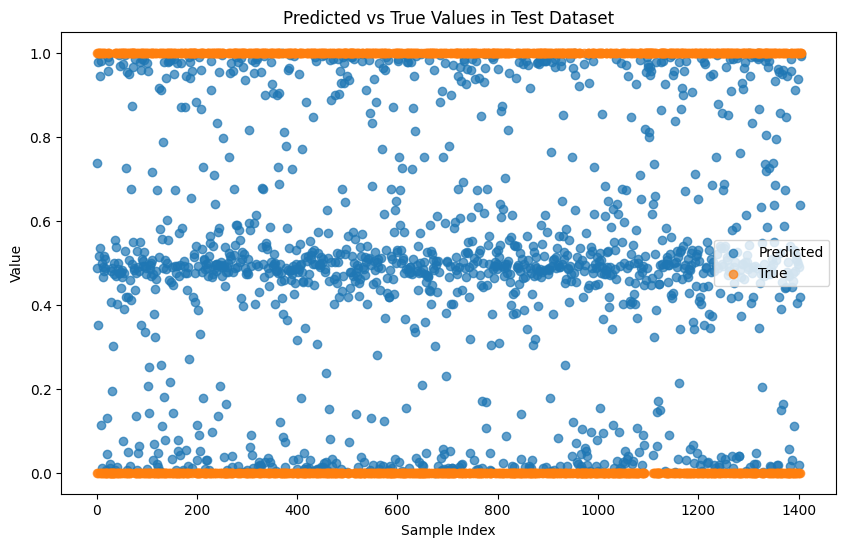

In [182]:
import matplotlib.pyplot as plt

# Get the model predictions on the test dataset
model.eval()
with torch.no_grad():
    x, edge_index, edge_attr = test_data.x, test_data.edge_index, test_data.edge_attr
    edge_label_index, edge_label = test_data.edge_label_index, test_data.edge_label

    node_emb = model.gnn(x, edge_index, edge_attr)
    u_emb = node_emb[edge_label_index[0]]
    v_emb = node_emb[edge_label_index[1]]
    preds = model.link_predictor(u_emb, v_emb)

# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(preds)), preds.cpu().numpy(), label='Predicted', alpha=0.7)
plt.scatter(range(len(edge_label)), edge_label.cpu().numpy(), label='True', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Predicted vs True Values in Test Dataset')
plt.legend()
plt.show()

# Evaluation

In [110]:
sweep_config = {
    'method': 'bayes',  # bayes, grid, or random
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'   
    },
    'parameters': {
        'hidden_dim': {
            'values': [32, 64, 128]
        },
        'num_conv_layers': {
            'values': [2, 3, 4]
        },
        'num_linear_layers': {
            'values': [1, 2, 3]
        },
        'lr': {
            'distribution': 'log_uniform',
            'min': 1e-4,
            'max': 1e-2
        },
        'weight_decay': {
            'distribution': 'log_uniform',
            'min': 1e-5,
            'max': 1e-2
        },
        'dropout': {
            'values': [0.0, 0.2, 0.4]
        }
    }
}

In [ ]:
def train_sweep():
    with wandb.init() as run:
        config = wandb.config
        """
        model = LitGNN(
                input_dim=data.x.shape[1],
                conv_layers=config.num_conv_layers,
                link_predictor_layers=config.num_linear_layers,
                conv_hidden_dim=config.hidden_dim,
                link_hidden_dim=config.hidden_dim,
                learning_rate=config.lr,
                weight_decay=config.weight_decay,
                dropout_rate=config.dropout
            ) """
        
        model = LitGNN(input_dim=data.x.shape[1])

        trainer = pl.Trainer(
            max_epochs=50,
            logger=pl.loggers.WandbLogger(),
            callbacks=[
                pl.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                pl.callbacks.ModelCheckpoint(monitor='val_loss')
            ]
        )
        trainer.fit(model, train_loader, val_loader)
        trainer.test(model, test_loader)

In [115]:
# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="nba_lineup_prediction")
# Start the sweep agent
wandb.agent(sweep_id, function=train_sweep, count=5)  # Run 5 agents in parallel

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. lr uses log_uniform, where min/max specify base-e exponents. Use log_uniform_values to specify limit values.
wandb: WARNING   Violation 2. weight_decay uses log_uniform, where min/max specify base-e exponents. Use log_uniform_values to specify limit values.


Create sweep with ID: vlnj32yu
Sweep URL: https://wandb.ai/rokaati18-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem/nba_lineup_prediction/sweeps/vlnj32yu


wandb: Agent Starting Run: gvs58ert with config:
wandb: 	dropout: 0.2
wandb: 	hidden_dim: 32
wandb: 	lr: 1.0012672756607033
wandb: 	num_conv_layers: 4
wandb: 	num_linear_layers: 3
wandb: 	weight_decay: 1.002390598864212


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | gnn            | GNNModel       | 13.4 K | train
1 | link_predictor | LinkPredictor  | 8.3 K  | train
2 | loss_fn        | BCELoss        | 0      | train
3 | train_acc      | BinaryAccuracy | 0      | train
4 | val_acc        | BinaryAccuracy | 0      | train
5 | test_acc       | BinaryAccuracy | 0      | train
6 | train_auroc    | BinaryAUROC    | 0      | train
7 | val_auroc      | BinaryAUROC    | 0      | train
8 | test_auroc     | BinaryAUROC    | 0      | tr

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] Train Loss: 0.7640
Train Accuracy: 0.4384
Train AUC: 0.4020
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=8ert, train_loss=0.764, train_acc=0.438, train_auc=0.402, val_loss=0.683, val_acc=0.544, val_auc=0.664]        Train Loss: 0.7016
Train Accuracy: 0.5184
Train AUC: 0.5299
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=8ert, train_loss=0.702, train_acc=0.518, train_auc=0.530, val_loss=0.673, val_acc=0.588, val_auc=0.722]        Train Loss: 0.6971
Train Accuracy: 0.5424
Train AUC: 0.6136
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=8ert, train_loss=0.697, train_acc=0.542, train_auc=0.614, val_loss=0.668, val_acc=0.597, val_auc=0.735]        Train Loss: 0.6828
Train Accuracy: 0.6168
Train AUC: 0.7031
Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=8ert, train_loss=0.683, train_acc=0.617, train_auc=0.703, val_loss=0.664, val_acc=0.628, val_auc=0.740]        Train Loss: 0.6702
Train Accuracy: 0.6128
Train AUC: 0.71

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s, v_num=8ert, train_loss=0.555, train_acc=0.726, train_auc=0.798, val_loss=0.536, val_acc=0.714, val_auc=0.812]


wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.11it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7133712768554688
        test_auc             0.803183376789093
        test_loss            0.542712390422821
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
test_acc,▁
test_auc,▁
test_loss,▁
train_acc,▁
train_auc,▁
train_loss,▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▁▃▃▄▇██████████████▇▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_auc,▁▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███████
val_loss,██▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁


wandb: Agent Starting Run: 29vsxzgs with config:
wandb: 	dropout: 0
wandb: 	hidden_dim: 128
wandb: 	lr: 1.0069905368863663
wandb: 	num_conv_layers: 3
wandb: 	num_linear_layers: 3
wandb: 	weight_decay: 1.0017362521182134


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | gnn            | GNNModel       | 13.4 K | train
1 | link_predictor | LinkPredictor  | 8.3 K  | train
2 | loss_fn        | BCELoss        | 0      | train
3 | train_acc      | BinaryAccuracy | 0      | train
4 | val_acc        | BinaryAccuracy | 0      | train
5 | test_acc       | BinaryAccuracy | 0      | train
6 | train_auroc    | BinaryAUROC    | 0      | train
7 | val_auroc      | BinaryAUROC    | 0      | train
8 | test_auroc     | BinaryAUROC    | 0      | tr

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] Train Loss: 0.8716
Train Accuracy: 0.4432
Train AUC: 0.4156
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=xzgs, train_loss=0.872, train_acc=0.443, train_auc=0.416, val_loss=0.733, val_acc=0.439, val_auc=0.361]        Train Loss: 0.7728
Train Accuracy: 0.4576
Train AUC: 0.4378
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=xzgs, train_loss=0.773, train_acc=0.458, train_auc=0.438, val_loss=0.731, val_acc=0.500, val_auc=0.542]        Train Loss: 0.7203
Train Accuracy: 0.5392
Train AUC: 0.5274
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=xzgs, train_loss=0.720, train_acc=0.539, train_auc=0.527, val_loss=0.716, val_acc=0.514, val_auc=0.634]        Train Loss: 0.7026
Train Accuracy: 0.5944
Train AUC: 0.6082
Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=xzgs, train_loss=0.703, train_acc=0.594, train_auc=0.608, val_loss=0.692, val_acc=0.628, val_auc=0.715]        Train Loss: 0.6960
Train Accuracy: 0.6288
Train AUC: 0.65

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s, v_num=xzgs, train_loss=0.563, train_acc=0.724, train_auc=0.791, val_loss=0.523, val_acc=0.726, val_auc=0.818]


wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7140824794769287
        test_auc            0.8106640577316284
        test_loss           0.5292726159095764
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
test_acc,▁
test_auc,▁
test_loss,▁
train_acc,▁
train_auc,▁
train_loss,▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▂▃▅██████████████████████████▇▇▇▇▇▇▇▇▇▇
val_auc,▁▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████████
val_loss,██▇▇▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁


wandb: Agent Starting Run: mtxkct6f with config:
wandb: 	dropout: 0
wandb: 	hidden_dim: 64
wandb: 	lr: 1.0008077174098855
wandb: 	num_conv_layers: 4
wandb: 	num_linear_layers: 3
wandb: 	weight_decay: 1.0006864712882424


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | gnn            | GNNModel       | 13.4 K | train
1 | link_predictor | LinkPredictor  | 8.3 K  | train
2 | loss_fn        | BCELoss        | 0      | train
3 | train_acc      | BinaryAccuracy | 0      | train
4 | val_acc        | BinaryAccuracy | 0      | train
5 | test_acc       | BinaryAccuracy | 0      | train
6 | train_auroc    | BinaryAUROC    | 0      | train
7 | val_auroc      | BinaryAUROC    | 0      | train
8 | test_auroc     | BinaryAUROC    | 0      | tr

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] Train Loss: 0.7224
Train Accuracy: 0.5224
Train AUC: 0.5322
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=ct6f, train_loss=0.722, train_acc=0.522, train_auc=0.532, val_loss=0.674, val_acc=0.752, val_auc=0.743]        Train Loss: 0.6956
Train Accuracy: 0.6000
Train AUC: 0.6114
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=ct6f, train_loss=0.696, train_acc=0.600, train_auc=0.611, val_loss=0.666, val_acc=0.756, val_auc=0.745]        Train Loss: 0.6862
Train Accuracy: 0.6600
Train AUC: 0.6537
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=ct6f, train_loss=0.686, train_acc=0.660, train_auc=0.654, val_loss=0.659, val_acc=0.753, val_auc=0.745]        Train Loss: 0.7043
Train Accuracy: 0.6992
Train AUC: 0.7034
Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=ct6f, train_loss=0.704, train_acc=0.699, train_auc=0.703, val_loss=0.656, val_acc=0.754, val_auc=0.748]        Train Loss: 0.6772
Train Accuracy: 0.7208
Train AUC: 0.72

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s, v_num=ct6f, train_loss=0.540, train_acc=0.735, train_auc=0.809, val_loss=0.505, val_acc=0.746, val_auc=0.839]

wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7311521768569946
        test_auc            0.8296064734458923
        test_loss           0.5097132921218872
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_auc,▁
test_loss,▁
train_acc,▁
train_auc,▁
train_loss,▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_acc,▆█▇▇▂▁▂▄▆▅▅▆▅▅▅▅▄▄▃▃▄▅▃▄▅▄▃▂▂▂▄▄▅▅▅▅▄▃▁▄
val_auc,▂▂▂▂▂▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_loss,██▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁


wandb: Agent Starting Run: 9v5ysxqp with config:
wandb: 	dropout: 0
wandb: 	hidden_dim: 64
wandb: 	lr: 1.0088366135113855
wandb: 	num_conv_layers: 2
wandb: 	num_linear_layers: 1
wandb: 	weight_decay: 1.0035090792074977


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | gnn            | GNNModel       | 13.4 K | train
1 | link_predictor | LinkPredictor  | 8.3 K  | train
2 | loss_fn        | BCELoss        | 0      | train
3 | train_acc      | BinaryAccuracy | 0      | train
4 | val_acc        | BinaryAccuracy | 0      | train
5 | test_acc       | BinaryAccuracy | 0      | train
6 | train_auroc    | BinaryAUROC    | 0      | train
7 | val_auroc      | BinaryAUROC    | 0      | train
8 | test_auroc     | BinaryAUROC    | 0      | tr

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] Train Loss: 0.7736
Train Accuracy: 0.5312
Train AUC: 0.5480
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=sxqp, train_loss=0.774, train_acc=0.531, train_auc=0.548, val_loss=0.669, val_acc=0.676, val_auc=0.734]        Train Loss: 0.7433
Train Accuracy: 0.6064
Train AUC: 0.6065
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=sxqp, train_loss=0.743, train_acc=0.606, train_auc=0.607, val_loss=0.672, val_acc=0.666, val_auc=0.730]        Train Loss: 0.7223
Train Accuracy: 0.6376
Train AUC: 0.6528
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=sxqp, train_loss=0.722, train_acc=0.638, train_auc=0.653, val_loss=0.676, val_acc=0.656, val_auc=0.727]        Train Loss: 0.6813
Train Accuracy: 0.6456
Train AUC: 0.6947
Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=sxqp, train_loss=0.681, train_acc=0.646, train_auc=0.695, val_loss=0.670, val_acc=0.667, val_auc=0.733]        Train Loss: 0.6958
Train Accuracy: 0.6584
Train AUC: 0.67

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s, v_num=sxqp, train_loss=0.578, train_acc=0.729, train_auc=0.794, val_loss=0.556, val_acc=0.738, val_auc=0.821]

wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.72901850938797
        test_auc             0.813040554523468
        test_loss           0.5577583909034729
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_acc,▁
test_auc,▁
test_loss,▁
train_acc,▁
train_auc,▁
train_loss,▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▃▂▁▃▄▄▄▃▂▂▂▂▂▄▆▇▇▇▇██████▇▇▇▇▇▇██▇▇▇▇▇▇▇
val_auc,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇████
val_loss,████▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▁


wandb: Agent Starting Run: vso5vjne with config:
wandb: 	dropout: 0
wandb: 	hidden_dim: 128
wandb: 	lr: 1.0055782236327275
wandb: 	num_conv_layers: 4
wandb: 	num_linear_layers: 3
wandb: 	weight_decay: 1.0012336137266666


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | gnn            | GNNModel       | 13.4 K | train
1 | link_predictor | LinkPredictor  | 8.3 K  | train
2 | loss_fn        | BCELoss        | 0      | train
3 | train_acc      | BinaryAccuracy | 0      | train
4 | val_acc        | BinaryAccuracy | 0      | train
5 | test_acc       | BinaryAccuracy | 0      | train
6 | train_auroc    | BinaryAUROC    | 0      | train
7 | val_auroc      | BinaryAUROC    | 0      | train
8 | test_auroc     | BinaryAUROC    | 0      | tr

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] Train Loss: 0.9042
Train Accuracy: 0.4400
Train AUC: 0.4297
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=vjne, train_loss=0.904, train_acc=0.440, train_auc=0.430, val_loss=0.723, val_acc=0.322, val_auc=0.285]        Train Loss: 0.7765
Train Accuracy: 0.4640
Train AUC: 0.4943
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=vjne, train_loss=0.777, train_acc=0.464, train_auc=0.494, val_loss=0.714, val_acc=0.494, val_auc=0.429]        Train Loss: 0.7623
Train Accuracy: 0.4904
Train AUC: 0.4967
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=vjne, train_loss=0.762, train_acc=0.490, train_auc=0.497, val_loss=0.695, val_acc=0.518, val_auc=0.620]        Train Loss: 0.7171
Train Accuracy: 0.5520
Train AUC: 0.5741
Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=vjne, train_loss=0.717, train_acc=0.552, train_auc=0.574, val_loss=0.681, val_acc=0.601, val_auc=0.701]        Train Loss: 0.7390
Train Accuracy: 0.5768
Train AUC: 0.59

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s, v_num=vjne, train_loss=0.573, train_acc=0.706, train_auc=0.786, val_loss=0.550, val_acc=0.734, val_auc=0.824]


wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7325747013092041
        test_auc            0.8178149461746216
        test_loss           0.5520617365837097
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
test_acc,▁
test_auc,▁
test_loss,▁
train_acc,▁
train_auc,▁
train_loss,▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▄▄▆▇███████████████████████████████████
val_auc,▁▃▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,██▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁
